In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [101]:
dataset_dir = 'dataset/original_data'

datasets = os.listdir(dataset_dir)
datasets_df = pd.DataFrame({'filenames': datasets})

In [102]:
classes = ['concentrating', 'neutral']#, 'relaxed']
datasets_by_class = {'concentrating':[], 'neutral':[], 'relaxed':[]}
test_sets_by_class = {'concentrating':[], 'neutral':[], 'relaxed':[]}
window_size = 256 #samples


for class_name in classes:
    datasets = datasets_df[datasets_df['filenames'].str.contains(class_name)]

    for filename in datasets['filenames']:
        sub_df = pd.read_csv(f"{dataset_dir}/{filename}") 
        train_raw, test_raw = train_test_split(sub_df, test_size=0.2, random_state=42)
        
        # NOTE: Split the data after reading, THEN perform sliding window
        
        # TRAINING DATA
        train_windows = []
        cur_window = []
        sample_count = 0

        row=0
        while row < train_raw.shape[0]:
            sample_count+=1
            cur_window.append(train_raw.iloc[row])

            if sample_count == window_size:
                train_windows.append(cur_window)
                cur_window = []
                sample_count = 0
                row-=window_size//2

            row+=1

        # TEST DATA
        test_windows = []
        cur_window = []
        sample_count = 0

        row=0
        while row < test_raw.shape[0]:
            sample_count+=1
            cur_window.append(test_raw.iloc[row])

            if sample_count == window_size:
                test_windows.append(cur_window)
                cur_window = []
                sample_count = 0
                row-=window_size//2

            row+=1

        # duplicates = 0
        # for u in train_windows:
        #     for v in test_windows:
        #         if np.array_equal(u,v):
        #             duplicates+=1

        # print(duplicates)


        datasets_by_class[class_name]+=train_windows
        test_sets_by_class[class_name]+=test_windows
        

In [103]:
concentrating_train_data = np.asarray(datasets_by_class['concentrating'], dtype='object')
neutral_train_data = np.asarray(datasets_by_class['neutral'], dtype='object')

concentrating_test_data = np.asarray(test_sets_by_class['concentrating'], dtype='object')
neutral_test_data = np.asarray(test_sets_by_class['neutral'], dtype='object')
# relaxed_data = np.asarray(datasets_by_class['relaxed'], dtype='object')

In [104]:
print("Training Data")
print(concentrating_train_data.shape)
print(neutral_train_data.shape)
# print(relaxed_data.shape)

print("Testing Data")
print(concentrating_test_data.shape)
print(neutral_test_data.shape)

Training Data
(596, 256, 6)
(577, 256, 6)
Testing Data
(139, 256, 6)
(134, 256, 6)


In [105]:
matrix = concentrating_train_data[0][:,1]
print(matrix.shape)

(256,)


In [107]:
# One sample
concentrating_train_data[0]

array([[1533222772.977, 49.316, 35.645, 309.57, 20.508, 23.438],
       [1533222792.173, -1.465, 45.41, 313.965, 5.859, 58.594],
       [1533222790.916, 44.434, 54.688, 131.348, 11.719, -50.293],
       ...,
       [1533222785.862, 58.594, 50.293, 370.117, 19.043, 22.461],
       [1533222784.742, 65.43, 46.875, 299.316, 19.043, 26.855],
       [1533222747.943, 14.648, 38.086, 70.801, 12.207, 78.125]],
      dtype=object)

In [108]:
X_train = concentrating_train_data[:, :, 1:5]  # Remove the first column
X_train = np.concatenate([X_train, neutral_train_data[:, :, 1:5]], axis=0)

X_test = concentrating_test_data[:, :, 1:5]  # Remove the first column
X_test = np.concatenate([X_test, neutral_test_data[:, :, 1:5]], axis=0)


y_train = np.array([0] * concentrating_train_data[:, :, 1:5].shape[0] + [1] * neutral_train_data[:, :, 1:5].shape[0])
y_test = np.array([0] * concentrating_test_data[:, :, 1:5].shape[0] + [1] * neutral_test_data[:, :, 1:5].shape[0])


In [109]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)


In [110]:
print(X_train.shape)
print(y_train.shape)

(1173, 256, 4)
(1173,)


In [111]:
def transform_set(scalar, data, fit=False):
    original_shape = data.shape 
    reshaped = data.reshape(-1, data.shape[-1]) 

    if fit:
        reshaped = scalar.fit_transform(reshaped)
    else:
        reshaped = scalar.transform(reshaped)
        
    reshaped = reshaped.reshape(original_shape)

    return reshaped

In [112]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler
X_scalar = MinMaxScaler()
X_train_scaled = transform_set(X_scalar, X_train, fit=True)
X_test_scaled = transform_set(X_scalar, X_test, fit=False)

In [113]:
print("X data:", X_train.shape, X_test.shape)
print("y data:", y_train.shape, y_test.shape)

X data: (1173, 256, 4) (273, 256, 4)
y data: (1173,) (273,)


In [114]:
X_train_scaled.shape

(1173, 256, 4)

In [115]:
# X_train_joined = X_train_scaled.reshape((X_train_scaled.shape[0]*X_train_scaled.shape[1],4))

In [116]:
from tensorflow import keras
from tensorflow.keras import layers

In [117]:
# Define the input shape (256x4)
input_shape = (256, 4) 

# Build the CNN model
model = keras.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Two output neurons for two classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

/home/babybacon/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 254, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 127, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 125, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 60, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       983,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,625 (3.87 MB)

 Trainable params: 1,014,625 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
model.fit(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test))

Epoch 1/20


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5477 - loss: 0.7213 - val_accuracy: 0.5092 - val_loss: 0.6284
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6461 - loss: 0.6002 - val_accuracy: 0.8388 - val_loss: 0.4755
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7892 - loss: 0.4861 - val_accuracy: 0.6337 - val_loss: 0.6112
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7796 - loss: 0.5039 - val_accuracy: 0.8571 - val_loss: 0.3652
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8229 - loss: 0.3855 - val_accuracy: 0.9158 - val_loss: 0.2708
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8555 - loss: 0.3318 - val_accuracy: 0.7656 - val_loss: 0.3382
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8574 - loss: 0.3045 - val_accuracy: 0.9634 - val_loss: 0.1436
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9492 - loss: 0.1582 - val_accuracy: 0.9634 - val_loss: 0.1271
Ep

In [60]:
X_train_scaled[0].shape
X_test_scaled[0].shape

(256, 4)

In [121]:
model.save('models/m1.keras')

In [62]:
preds = model.predict(X_test_scaled)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [63]:
score = 0

for i in range(preds.shape[0]):
    is_equal = (np.round(preds[i]) == np.round(y_test[i]))
    if is_equal:
        score+=1

print(f"{score}/{preds.shape[0]}")

288/289


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [25]:
import matplotlib.pyplot as plt


In [29]:
X_test_scaled[0].shape

(256, 4)

In [69]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([155, 134]))

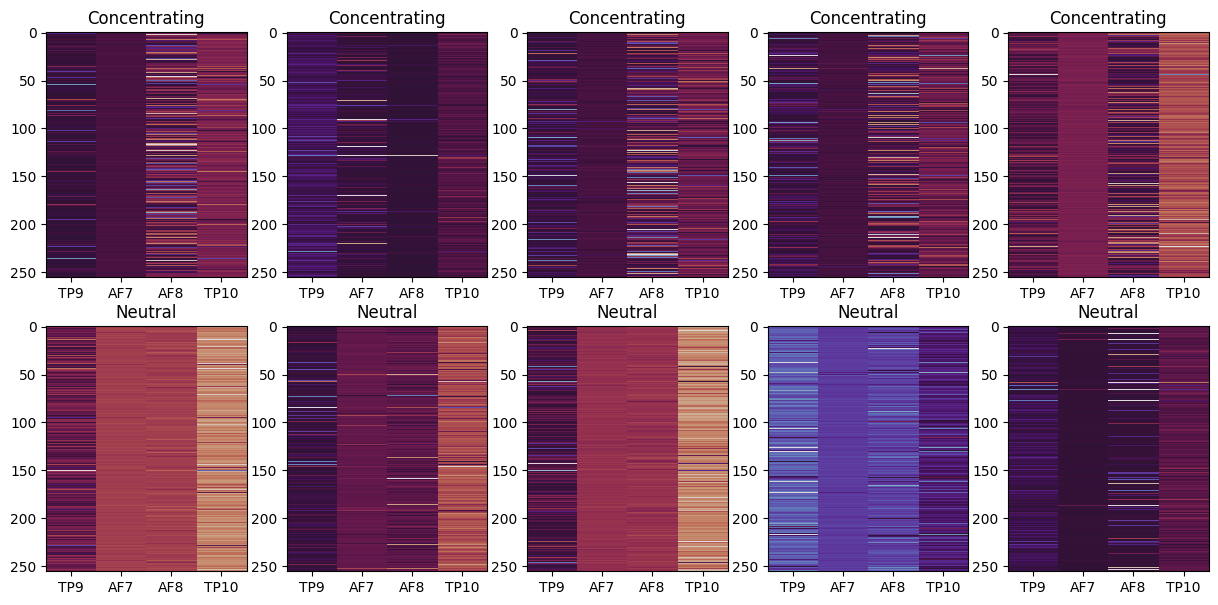

In [87]:
from matplotlib.lines import Line2D

# Assuming X_test_scaled and y_test are already defined, and each image is 2D
fig, axes = plt.subplots(2, 5, figsize=(15, 7))  # Create a 2x5 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate through it


positives = 0
negatives = 0

i = 0
while positives<5 or negatives<5:

    if (y_train[i] == 1 and positives<5) or (y_train[i] == 0 and negatives<5):
        ax = axes[positives+negatives]  # Select the subplot for the current image
        ax.imshow(X_train_scaled[i], cmap='twilight', interpolation='nearest', aspect='auto')
        ax.set_title(
            'Concentrating' if y_train[i]==0 else 'Neutral'
            )  # Set title with the label
        # ax.axis('off')  # Hide axis for a cleaner look
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels(['TP9','AF7','AF8','TP10'])

        positives+=int(y_train[i]==1)
        negatives+=int(y_train[i]==0)

    i+=1

# Show the plot
plt.savefig('classes.png')
plt.show()

In [ ]:
def plot_sample(sample):
    variables = ['TP9','AF7','AF8','TP10','Right AUX']

    # Number of samples
    num_samples = sample.shape[0]

    # Create a figure with 5 subplots (1 column and 5 rows)
    fig, axes = plt.subplots(5, 1, figsize=(10, 15))

    # Plot each of the 5 variables in separate subplots
    for i in range(sample.shape[1]):
        axes[i].plot(range(num_samples), sample[:, i], label=f'Variable {i+1}')
        axes[i].set_title(f'{variables[i]}')
        axes[i].set_xlabel('Sample Index')
        axes[i].set_ylabel('Value')
        axes[i].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plot
    plt.show()

In [122]:
import pickle

with open('models/X_scalar.pckl', 'wb') as file:
    # Pickle the data and write it to the file
    pickle.dump(X_scalar, file)


In [ ]:
# Importing libraries using import keyword.
import math
import matplotlib.pyplot as plt

In [ ]:
eeg_data = X_train_scaled[1]  # Simulated EEG data

eeg_data = eeg_data.reshape(4,256)

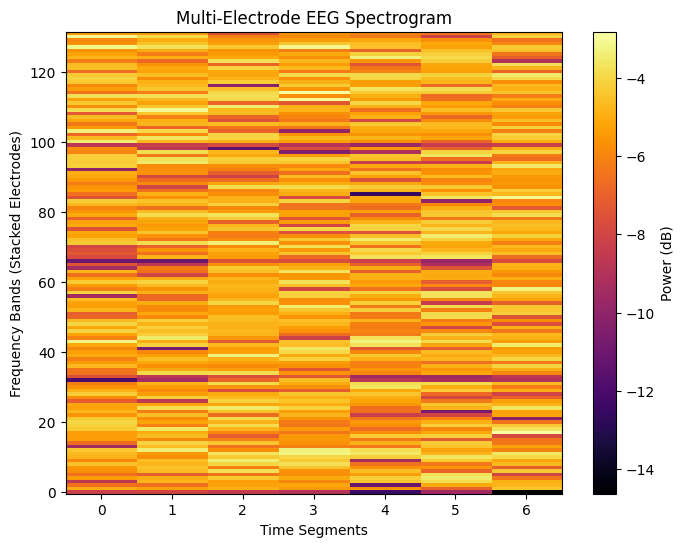

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Example EEG data (4 electrodes, 256 samples per second)
fs = 256  # Sampling frequency in Hz
time = np.linspace(0, 1, fs)  # 1 second of data
eeg_data = np.random.randn(4, fs)  # Simulated EEG data (replace with real EEG)

# Initialize a list to store spectrograms
spectrograms = []

# Compute the spectrogram for each electrode
for i in range(eeg_data.shape[0]):
    f, t, Sxx = spectrogram(eeg_data[i, :], fs=fs, nperseg=64, noverlap=32)
    spectrograms.append(np.log(Sxx + 1e-8))  # Log transform for better visualization

# Stack spectrograms vertically to form a single image
spectrogram_image = np.vstack(spectrograms)

# Plot the combined spectrogram
plt.figure(figsize=(8, 6))
plt.imshow(spectrogram_image, aspect='auto', cmap='inferno', origin='lower')
plt.title('Multi-Electrode EEG Spectrogram')
plt.xlabel('Time Segments')
plt.ylabel('Frequency Bands (Stacked Electrodes)')
plt.colorbar(label='Power (dB)')
plt.show()

In [ ]:
spectrogram_image.shape

(132, 7)